In [51]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
#figsize(14, 7)

# PID Control of Thermal Systems

Not required for MECH 217, but interesting.

<a href="http://www.youtube.com/watch?feature=player_embedded&v=THUka7Q8kj0
" target="_blank"><img src="http://img.youtube.com/vi/THUka7Q8kj0/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="240" height="180" border="10" /></a>

In this video we developed the idea that the response of a temperature sensor to it's surroundings would follow a first order model

\begin{equation} 
\frac{dT_s}{dt} = \frac{1}{\tau}(T_a-T_s)\quad{\rm where}\quad \tau = \frac{mC_p}{hA_s}
\end{equation}

and $t$ is time, $T_a$ the temperature of the surroundings and $T_s$ the temperature of the sensor. We can approximate this following Euler's method as

\begin{equation} 
T_{s_{\rm new}} = T_{s_{\rm old}} + 
\frac{1}{\tau}
(T_{a_{\rm old}}-T_{s_{\rm old}})\Delta t
\end{equation}

to estimate the new value for the sensor temperature a short time later based on the conditions at the previous time step.

For a step change in temperature at time $t_0$, we have an analytical solution from MTHE 225 of 

\begin{equation}
T_s = T_1 - e^{-(t-t_0)/\tau}(T_1-T_0) \quad\quad{\rm for}\quad\quad t\ge t_0
\end{equation}

## Time Response for a Heated Block (or Bath)

\begin{equation} 
\frac{dT_b}{dt} = \frac{hA}{mC_p}(T_a-T_b) + \frac{Q}{mC_p}
\end{equation}

Governs the changing temperature for a block of material with heat input Q. The block will get warmer by the heating and by convection if the ambient surroundings are warmer. The equation can be simplified if we have measured the time constant with heater switch off  

\begin{equation} 
\frac{dT_b}{dt} = \frac{1}{\tau_b}(T_a-T_b) + \frac{Q}{mC_p}
\end{equation}

and Euler's method can be applied. If I attach the two sensors to the block, then I could turn the heater up and down to control the temperature, based on whatever algorithm I chose for that control. The time constants for the sensors will depend on how well they are attached to the block. The code below uses a simple set/reset thermostat control.

## Q2 Add a Differential Equation to the System
Add the necessary code to this model to include a calculation of new values for TB[i], the temperature of the block. Notice that the code for the two sensor temperatures has been changed to reflect that they are interacting with the block at TB. Constant values representing the characteristics of the block are in the preamble code. Why does T overshoot more on the high side than on the low side of the set/reset range?

(-100, 2100)

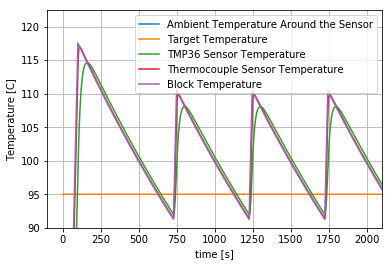

In [185]:
TauS =2000
TauB = 2000         # the time constant for the block
mCpB = 2000         # the heat capacity for the block
TauTC = 4
TauTMP = 20
t0 = 5                      # the time of the step change
tr = 12000                   # time range of interest
dtC = 1           # the control time step
nC = 10           # number of simulation steps in a control step
dt = dtC/nC           # the simulation time step
n=int(tr/dt)             # enough points to be nearly continuous try a smaller number

def Tact(t):                # The actual temperature as a function of time
    return 20               # constant ambient temperature

Heat = 1                    # Heat on or off
Qmax = 2000                 # Max Heat in Watts
Tset = 92
Treset = 98
Ttarget = (Tset+Treset)/2

def QSR(t,T,err,d,i):       # Return the amount of heat generated by the heater as a function of 
    global Heat             # time and sensor temperature
    if(T > Treset): Heat = 0# turn off if too hot
    if(T < Tset):  Heat = 1 # turn on if too cold, don't switch too often
    return Qmax * Heat      # heater either on or off


def blockCalc(Q,noPlot = 0):
    # Plot the step function and the ODE solution for a continuous system
    t = np.linspace(0,tr,n)
    T = t.copy()
    for i in range (0,n): T[i] = Tact(t[i])
    TTMP = T.copy()
    TTC = T.copy()
    TB = T.copy()
    Tobj = Ttarget * ones(len(t))
    Terr = zeros(len(T))        # the error at each step
    QA = zeros(len(T))        # the heat input at each step
    iTerr = 0        # integral of the error starts out as zero

    for i in range (1,n):  # advance 3 ODEs simultanteously 
        TTC[i] = TTC[i-1] + 1/TauTC * (TB[i-1]-TTC[i-1]) * dt
        TTMP[i] = TTMP[i-1] + 1/TauTMP * (TB[i-1]-TTMP[i-1]) * dt
        Ts = TTMP[i]
        TB[i] = TB[i-1] + (1/TauB * (T[i-1]-TB[i-1]) + QA[i-1]/mCpB) * dt 
        Terr[i] = Tobj[i]-Ts
        dTerr = (Terr[i]-Terr[i-1])/dt
        iTerr += Terr[i]*dt
        if(i%nC == 0): QA[i] = Q(t[i],Ts,Terr[i],dTerr,iTerr)
        else: QA[i] = QA[i-1]
    
    if(noPlot == 0):
        plot(t,T,label = 'Ambient Temperature Around the Sensor')
        plot(t,Tobj,label = 'Target Temperature')
        plot(t,TTMP,label = 'TMP36 Sensor Temperature')
        plot(t,TTC,label = 'Thermocouple Sensor Temperature')
        plot(t,TB,label = 'Block Temperature')
        xlabel('time [s]')
        ylabel('Temperature [C]')
        legend()
        grid()
    return (t,TB)
    
t,TB1 = blockCalc(QSR)
ylim(90)
xlim(-100,2100)


(90, 122.30821090362149)

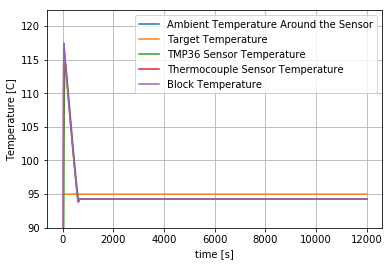

In [172]:
def QP(t,T,err,d,i,Gp = 100 ):        # Return the amount of heat generated by the heater as a function of 
    return max(0,Gp * err)   

blockCalc(QP)
ylim(90)


(90, 109.18531047076539)

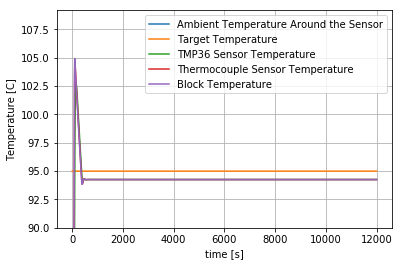

In [173]:
def QPM(t,T,err,d,i,Gp = 100 ):        # Return the amount of heat generated by the heater as a function of 
    return max(0,min(Qmax,Gp * err))   

blockCalc(QPM)
ylim(90)


(90, 113.58726567255962)

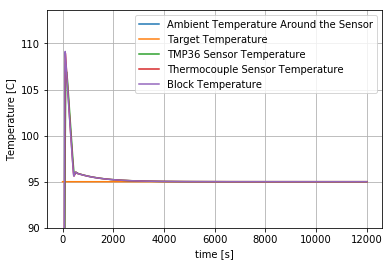

In [186]:
def QPIM(t,T,err,d,i,Gp = 100,Gi = .1 ):        # Return the amount of heat generated by the heater as a function of 
    Q = Gp * err + Gi * i
    return max(0,min(Qmax,Q))   

blockCalc(QPIM)
ylim(90)


(90, 100.63165420931806)

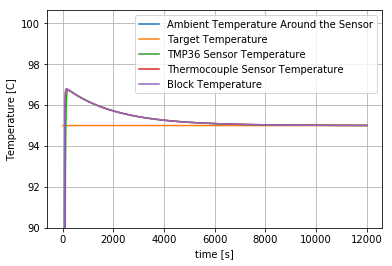

In [187]:
def QPIDM(t,T,err,d,i,Gp = 200,Gi = .1,Gd = 4000):        # Return the amount of heat generated by the heater as a function of 
    #print (d)
    Q = Gp * err + Gi * i + Gd * d
    return max(0,min(Qmax,Q))   

blockCalc(QPIDM)
ylim(90)
